In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
project_root = os.path.abspath("../..")  # one level up from /notebooks
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve
from src.image_generation import moffat, sersic
from src.analysis import gaussian_weight, wiener_deconvolution, calculate_gaap_flux
import matplotlib as mpl
from tqdm import tqdm
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings("ignore")

In [3]:
from scipy.ndimage import map_coordinates
def calculate_gaap_flux(image, psf, weight, centers):
    """
    Placeholder function for flux calculation.
    """
    weight_rescale = wiener_deconvolution(weight, psf, 0)
    flux_map = fftconvolve(image, weight_rescale[::-1, ::-1], mode='same')

    centers = np.asarray(centers)
    ys = centers[:, 1]
    xs = centers[:, 0]

    valid = np.isfinite(xs) & np.isfinite(ys)
    measured_F = np.full(len(centers), np.nan, dtype=np.float32)
    measured_F[valid] = map_coordinates(flux_map, [ys[valid], xs[valid]], order=1)

    x_negative = image[image<0].flatten()
    sigma = np.sqrt(np.sum(x_negative ** 2) * np.sum(weight_rescale ** 2) / len(x_negative))

    return measured_F, weight_rescale

def estimate_sigma(noise_image, weight, maxlag):
    local_covariance = covariance_fft2d(noise_image, maxlag)
    variance = weighted_variance_lag(weight, local_covariance, maxlag)
    return np.sqrt(variance)

def covariance_fft2d(image, maxlag):
    """
    Compute 2D covariance by FFT of background-subtracted residual.
    - image: 2D array (float)
    - maxlag: integer; returns covariance for lags -maxlag..+maxlag in both axes
    Returns: cov (2*maxlag+1, 2*maxlag+1) centered at lag (0,0)
    """
    img = image.astype(float)
    h, w = img.shape
    img -= np.mean(img)
    
    ac = fftconvolve(img, img[::-1, ::-1], mode="same")

    ac_norm = ac / (h * w)

    cy, cx = h//2, w//2
    window = ac_norm[cy-maxlag:cy+maxlag+1, cx-maxlag:cx+maxlag+1]
    return window



def weighted_variance_lag(s, C_local, max_lag):
    H, W = s.shape
    V = 0.0
    for dy in range(-max_lag, max_lag + 1):
        for dx in range(-max_lag, max_lag + 1):
            y0 = max(0, -dy)
            y1 = min(H, H - dy)
            x0 = max(0, -dx)
            x1 = min(W, W - dx)
            s1 = s[y0:y1, x0:x1]
            s2 = s[y0 + dy:y1 + dy, x0 + dx:x1 + dx]
            V += np.sum(s1 * s2) * C_local[dy + max_lag, dx + max_lag]
    return V

In [4]:
# Set plot parameters
mpl.rcParams['image.cmap'] = 'grey'
mpl.rcParams['image.origin'] = 'lower'

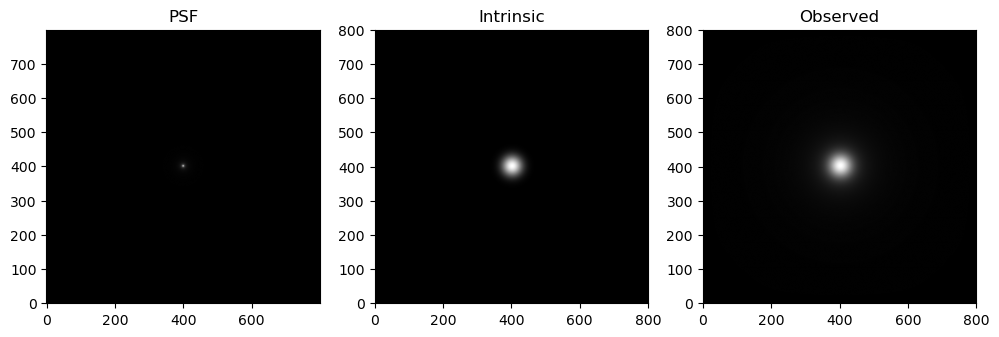

In [5]:
width = 800
height = 800
psf_sigma = 10

# Create PSF and Galaxy images
image_psf = moffat(width, height, 0.8, 2, n_spikes=0, Rc=2.0, spike_strength=1.0, spike_width=.1)
image_intrinsic = sersic(width, height, height / 2, width / 2, k=1.5, n=4, inclination=np.radians(60),
                         rotation=0, n_arms=2, bulge_strength=1, Rc=30)
image_intrinsic = gaussian_weight(height, width, height / 2, width / 2, 20, 20) * 1000
# Convolve the galaxy with the PSF
image = fftconvolve(image_intrinsic, image_psf, mode="same")

# Plot
fig, axs = plt.subplots(1, 3, figsize=(12, 8))
axs[0].imshow(image_psf)
axs[0].set_title("PSF")
axs[1].imshow(image_intrinsic, extent=(0, width, 0, height))
axs[1].set_title("Intrinsic")
axs[2].imshow(image, extent=(0, width, 0, height))
axs[2].set_title("Observed")
plt.show()

In [6]:
# Define weight function
weight = gaussian_weight(height, width, height / 2, width / 2, 20, 20)

# Calculate the aperture flux using the intrinsic image and weight function
true_F = np.sum(weight * image_intrinsic)
print(f'The aperture flux measured using the intrinsic image and weight function : {true_F:.6f}')

# Calculate the aperture flux using the observed image and rescaled weight function
measured_F, _ = calculate_gaap_flux(image, image_psf, weight, [(height / 2, width / 2)])
print(f'The aperture flux using the observed image and rescaled weight function : {measured_F[0]:.6f}')

The aperture flux measured using the intrinsic image and weight function : 0.198944
The aperture flux using the observed image and rescaled weight function : 0.198933


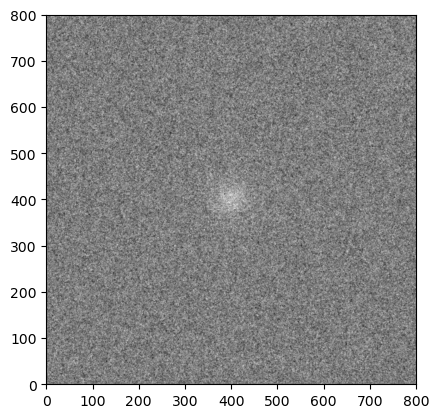

In [7]:
noise_psf = moffat(width, height, 2, 1)
noise = np.random.normal(0, .1, (height, width))
noise = fftconvolve(noise, noise_psf, mode="same") 
noisy_image = image+noise
plt.imshow(noisy_image, extent=(0, width, 0, height))
plt.show()

In [8]:
def gaussian_2d(xy, amplitude, x0, y0, sigma):
    x, y = xy
    r_2 = (x - x0)**2 + (y - y0)**2
    g = amplitude * np.exp(
        -r_2/(2*sigma**2)
    )
    return g.ravel()

Deconvolving weight function
Deconvolving weight function
Deconvolving weight function
Deconvolving weight function
Deconvolving weight function
Deconvolving weight function
Deconvolving weight function
Deconvolving weight function
Deconvolving weight function
Deconvolving weight function
Deconvolving weight function
Deconvolving weight function
Deconvolving weight function
Deconvolving weight function
Deconvolving weight function
Deconvolving weight function
Deconvolving weight function
Deconvolving weight function
Deconvolving weight function
Deconvolving weight function


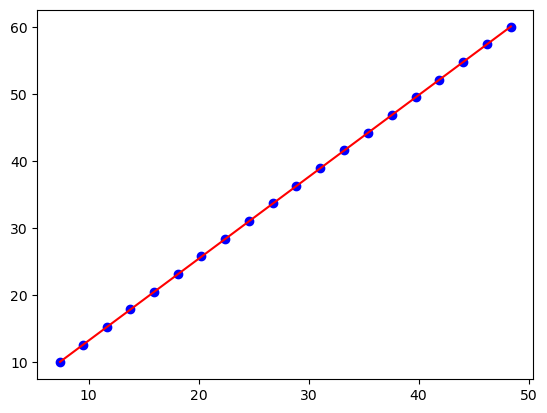

1.2187852410736595 1.0617096720295103


In [9]:
original_sizes = np.linspace(10, 60, 20)
weight_sigmas = np.full(len(original_sizes), np.nan)
for i,original_size in enumerate(original_sizes):
    weight = gaussian_weight(height//2, width//2, height / 4, width / 4, original_size, original_size)
    weight_rescale = wiener_deconvolution(weight, image_psf, 0)
    y = np.arange(weight_rescale.shape[0])
    x = np.arange(weight_rescale.shape[1])
    x, y = np.meshgrid(x, y)

    # Flatten image and coordinates
    xdata = np.vstack((x.ravel(), y.ravel()))
    ydata = weight_rescale.ravel()

    amplitude_guess = np.max(weight_rescale)
    x0_guess = np.argmax(np.sum(weight_rescale, axis=0))
    y0_guess = np.argmax(np.sum(weight_rescale, axis=1))
    sigma_guess = weight_rescale.shape[1]/4

    initial_guess = [amplitude_guess, x0_guess, y0_guess, sigma_guess]

    popt, _ = curve_fit(gaussian_2d, xdata, ydata, p0=initial_guess)

    amplitude, x0, y0, weight_sigma = popt
    weight_sigmas[i] = weight_sigma
A = np.column_stack((np.abs(weight_sigmas), np.ones_like(weight_sigmas)))
a, b = np.linalg.lstsq(A, original_sizes, rcond=None)[0]
plt.scatter(np.abs(weight_sigmas), original_sizes, color='blue')
plt.plot(np.abs(weight_sigmas), a * np.abs(weight_sigmas) + b, color='red')
plt.show()
print(a, b)

In [10]:
def best_original_size(image_sigma):
    return a * np.abs(image_sigma) + b

In [11]:
y = np.arange(noisy_image.shape[0])
x = np.arange(noisy_image.shape[1])
x, y = np.meshgrid(x, y)

# Flatten image and coordinates
xdata = np.vstack((x.ravel(), y.ravel()))
ydata = noisy_image.ravel()

amplitude_guess = np.max(noisy_image)
x0_guess = np.argmax(np.sum(noisy_image, axis=0))
y0_guess = np.argmax(np.sum(noisy_image, axis=1))
sigma_guess = noisy_image.shape[1]/4

initial_guess = [amplitude_guess, x0_guess, y0_guess, sigma_guess]

popt, _ = curve_fit(gaussian_2d, xdata, ydata, p0=initial_guess)

amplitude, x0, y0, image_sigma = popt
print(x0, y0)
print(image_sigma)

399.4865895231293 400.0189186856601
29.886232461854213


38.07692307692307
10 29.886232461854213 31.51486777322711


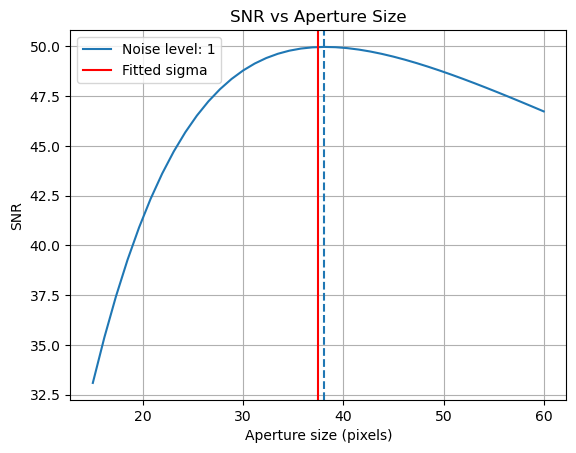

In [12]:
sizes = np.linspace(15, 60, 40)
for noise_levels in [1]:
    snr = np.zeros_like(sizes)
    maxlag = 1
    for i, size in enumerate(sizes):
        weight = gaussian_weight(height, width, height / 2, width / 2, size, size)
        flux, weight_new = calculate_gaap_flux(noisy_image, image_psf, weight, [(height / 2, width / 2)])
        sigma = estimate_sigma(noise * noise_levels, weight_new, maxlag)
        snr[i] = flux/ sigma 
    plt.plot(sizes, snr, label=f'Noise level: {noise_levels}')
    plt.axvline(sizes[np.argmax(snr)], linestyle='dashed')
print(sizes[np.argmax(snr)])
plt.axvline(best_original_size(image_sigma), color='red', label='Fitted sigma')
print(psf_sigma, image_sigma, np.sqrt(psf_sigma**2 + image_sigma**2))
plt.xlabel("Aperture size (pixels)")
plt.ylabel("SNR")
plt.title("SNR vs Aperture Size")
plt.grid()
plt.legend()
# plt.loglog()
plt.show()